<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Исследование-результата-A/A/B-эксперимента" data-toc-modified-id="Исследование-результата-A/A/B-эксперимента-1">Исследование результата A/A/B-эксперимента</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Описание-проекта:" data-toc-modified-id="Описание-проекта:-1.0.1">Описание проекта:</a></span></li><li><span><a href="#Описание-данных:" data-toc-modified-id="Описание-данных:-1.0.2">Описание данных:</a></span></li></ul></li><li><span><a href="#1.-Загрузим-данные-и-подготовим-их-к-анализу" data-toc-modified-id="1.-Загрузим-данные-и-подготовим-их-к-анализу-1.1">1. Загрузим данные и подготовим их к анализу</a></span></li><li><span><a href="#2.-Подготовим-данные" data-toc-modified-id="2.-Подготовим-данные-1.2">2. Подготовим данные</a></span></li><li><span><a href="#3.-Изучим-и-проверим-данные" data-toc-modified-id="3.-Изучим-и-проверим-данные-1.3">3. Изучим и проверим данные</a></span></li><li><span><a href="#4.-Изучим-воронку-событий" data-toc-modified-id="4.-Изучим-воронку-событий-1.4">4. Изучим воронку событий</a></span></li><li><span><a href="#5.-Изучим-результаты-эксперимента" data-toc-modified-id="5.-Изучим-результаты-эксперимента-1.5">5. Изучим результаты эксперимента</a></span></li><li><span><a href="#Вывод:" data-toc-modified-id="Вывод:-1.6">Вывод:</a></span></li></ul></li></ul></div>

# Исследование результата A/A/B-эксперимента

### Описание проекта:

Вы работаете в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи вашего мобильного приложения.

Изучите воронку продаж. Узнайте, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?

После этого исследуйте результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясните, какой шрифт лучше.

Создание двух групп A вместо одной имеет определённые преимущества. Если две контрольные группы окажутся равны, вы можете быть уверены в точности проведенного тестирования. Если же между значениями A и A будут существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов. Сравнение контрольных групп также помогает понять, сколько времени и данных потребуется для дальнейших тестов.

В случае общей аналитики и A/A/B-эксперимента работайте с одними и теми же данными. В реальных проектах всегда идут эксперименты. Аналитики исследуют качество работы приложения по общим данным, не учитывая принадлежность пользователей к экспериментам.

### Описание данных:
Каждая запись в логе — это действие пользователя, или событие.
- <code>EventName</code> — название события;
- <code>DeviceIDHash</code> — уникальный идентификатор пользователя;
- <code>EventTimestamp</code> — время события;
- <code>ExpId</code> — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

## 1. Загрузим данные и подготовим их к анализу

Загрузим необходимые библиотеки:

In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import warnings
import math as mth
from plotly import graph_objects as go
warnings.filterwarnings('ignore')

Откроем файл с данными и изучим общую информацию:

In [2]:
df = pd.read_csv('logs_exp.csv', sep='\t')
df.head(5)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


## 2. Подготовим данные

Заменим названия столбцов:

In [3]:
df.columns = ['event_name', 'uid', 'unix_time', 'exp_id']
df.head()

,event_name,uid,unix_time,exp_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


Проверим пропуски и типы данных:

In [4]:
df.isna().value_counts()

event_name  uid    unix_time  exp_id
False       False  False      False     244126
dtype: int64

Пропуски отстуствуют.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   event_name  244126 non-null  object
 1   uid         244126 non-null  int64 
 2   unix_time   244126 non-null  int64 
 3   exp_id      244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Откорректируем типы данных:

In [6]:
df['uid'] = df['uid'].astype('str')
df['exp_id'] = df['exp_id'].astype('str')
df['dt'] = pd.to_datetime(df['unix_time'], unit='s')
df.drop('unix_time', axis=1, inplace=True)

Добавим столбец с датами:

In [7]:
df['date'] = df['dt'].dt.date

Проверим дубликаты:

In [8]:
df.duplicated().sum()

413

В датасете имеются дубликаты. Дропнем их.

In [9]:
df = df.drop_duplicates()

In [10]:
df.head()

,event_name,uid,exp_id,dt,date
0,MainScreenAppear,4575588528974610257,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,248,2019-07-25 11:48:42,2019-07-25


## 3. Изучим и проверим данные

Посмотрим какие имеются типы событий:

In [11]:
event_names = df['event_name'].unique().tolist()
event_names

['MainScreenAppear',
 'PaymentScreenSuccessful',
 'CartScreenAppear',
 'OffersScreenAppear',
 'Tutorial']

Посмотрим сколько всего событий в логе:

In [12]:
df['event_name'].count()

243713

Посчитаем сколько всего пользователей в логе:

In [13]:
df['uid'].nunique()

7551

Посчитаем сколько в среднем событий приходится на пользователя:


,event_name
count,7551.000000
mean,32.275593
std,65.154219
min,1.000000
25%,9.000000
50%,20.000000
75%,37.000000
max,2307.000000


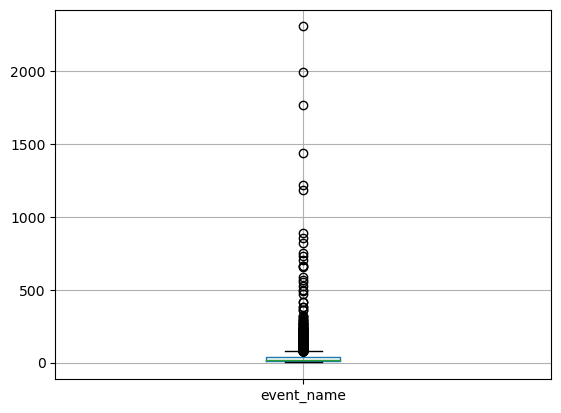

In [14]:
pte = df.pivot_table(index='uid', 
               values='event_name', 
               aggfunc='count')
pte.boxplot()
pte.describe()

Учитывая, что в данных есть выбросы, то лучше использовать медиану, т.к. она менее чувствительна к ним.

In [15]:
df.pivot_table(index='uid', 
               values='event_name', 
               aggfunc='count').median()[0]

20.0

Посмотрим на распределение событий во времени:

In [16]:
df['date'].min(), df['date'].max()

(datetime.date(2019, 7, 25), datetime.date(2019, 8, 7))

In [17]:
df['dt'].hist(bins=100, figsize=(20, 4), color='tan')

<AxesSubplot: >

Видим, что до 2019-08-01 данных значительно меньше, в связи с чем отбросим эти значения. Интересуемый нас период: с 1 по 7 августа 2019г.

In [18]:
df1 = df[df['dt'] >= '2019-08-01']
df1['dt'].hist(bins=50, figsize=(20, 4), color='tan')

<AxesSubplot: >

Выясним сколько пользователей потеряли, отбросив старые данные:

In [19]:
uid_lost = df['uid'].nunique() - df1['uid'].nunique()
uid_lost_perc = (df['uid'].nunique() - df1['uid'].nunique())/df['uid'].nunique()*100
'Потеряли {} ({:.2f}%) пользователей'.format(uid_lost, uid_lost_perc)

'Потеряли 17 (0.23%) пользователей'

Также выясним сколько событий потеряли, отбросив старые данные:

In [20]:
events_lost = df.shape[0] - df1.shape[0]
events_lost_perc = (df.shape[0] - df1.shape[0])/df.shape[0]*100
'Потеряли {} ({:.2f}%) событий'.format(events_lost, events_lost_perc)

'Потеряли 2826 (1.16%) событий'

Данная цифра не является критичной. Идем дальше.

Проверим, что у вас есть пользователи из всех трёх экспериментальных групп:

In [21]:
df1.head()

,event_name,uid,exp_id,dt,date
2828,Tutorial,3737462046622621720,246,2019-08-01 00:07:28,2019-08-01
2829,MainScreenAppear,3737462046622621720,246,2019-08-01 00:08:00,2019-08-01
2830,MainScreenAppear,3737462046622621720,246,2019-08-01 00:08:55,2019-08-01
2831,OffersScreenAppear,3737462046622621720,246,2019-08-01 00:08:58,2019-08-01
2832,MainScreenAppear,1433840883824088890,247,2019-08-01 00:08:59,2019-08-01


In [22]:
df1.pivot_table(index='exp_id', 
                values='uid', 
                aggfunc='count')

,uid
exp_id,
246,79302
247,77022
248,84563


## 4. Изучим воронку событий

Посмотрим, как часто события встречаются в логах:

In [23]:
df1.pivot_table(index='event_name', 
                values='date', 
                aggfunc='count').sort_values(by='date', ascending=False)

,date
event_name,
MainScreenAppear,117328
OffersScreenAppear,46333
CartScreenAppear,42303
PaymentScreenSuccessful,33918
Tutorial,1005


Можно предположить, что руководство (tutorial) никак не влияет на воронку продаж, и эти события следует отбросить.

In [24]:
df2 = df1[df1['event_name'] != 'Tutorial']

Посмотрим, сколько пользователей совершали каждое из этих событий:

In [25]:
pivot_table = df2.pivot_table(index='event_name', 
                              values='uid', 
                              aggfunc='nunique').sort_values(by='uid', ascending=False)
pivot_table.columns = ['uid_count']
pivot_table

,uid_count
event_name,
MainScreenAppear,7419
OffersScreenAppear,4593
CartScreenAppear,3734
PaymentScreenSuccessful,3539


Посчитаем долю пользователей, которые хоть раз совершали событие.

In [26]:
pivot_table['share_of_all_uid'] = round(pivot_table['uid_count']/df2['uid'].nunique()*100, 2)
pivot_table

,uid_count,share_of_all_uid
event_name,,
MainScreenAppear,7419,98.53
OffersScreenAppear,4593,61.00
CartScreenAppear,3734,49.59
PaymentScreenSuccessful,3539,47.00


Очевидно, что все события происходят в следующей цепочке:

MainScreenAppear -> OffersScreenAppear -> CartScreenAppear -> PaymentScreenSuccessful

По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем).

In [27]:
pivot_table['funnel_rate'] = round(pivot_table['uid_count'].div(pivot_table['uid_count'].shift(1, fill_value=0))*100, 2)
pivot_table[['uid_count', 'funnel_rate']]

,uid_count,funnel_rate
event_name,,
MainScreenAppear,7419,inf
OffersScreenAppear,4593,61.91
CartScreenAppear,3734,81.30
PaymentScreenSuccessful,3539,94.78


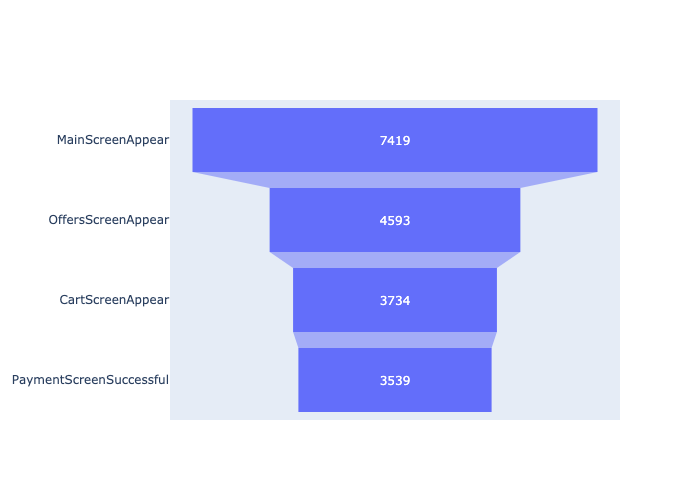

In [28]:
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'funnel_rate',
    y = pivot_table.index,
    x = pivot_table['uid_count'],
    ))

fig.show("png")

Видим, что на первом шаге (после просмотра главной страницы) теряется больше всего пользователей.

Посчитаем какая доля пользователей доходит от первого события до оплаты.

In [29]:
round(pivot_table.loc['PaymentScreenSuccessful', 'uid_count'] / pivot_table.loc['MainScreenAppear', 'uid_count'] * 100, 2)

47.7

47.7% посетителей сайта совершили хотя бы одну покупку.

Для дальнейших статистических тестов заменим строковые названия событий на дискретные значения от 1 до 4:

In [30]:
df2['event_id'] = df2['event_name'].copy()
df2['event_id'].replace(['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful'], [1, 2, 3, 4], inplace=True)
df2 = df2[['event_id', 'event_name', 'uid', 'exp_id', 'dt', 'date']]
df2.head()

,event_id,event_name,uid,exp_id,dt,date
2829,1,MainScreenAppear,3737462046622621720,246,2019-08-01 00:08:00,2019-08-01
2830,1,MainScreenAppear,3737462046622621720,246,2019-08-01 00:08:55,2019-08-01
2831,2,OffersScreenAppear,3737462046622621720,246,2019-08-01 00:08:58,2019-08-01
2832,1,MainScreenAppear,1433840883824088890,247,2019-08-01 00:08:59,2019-08-01
2833,1,MainScreenAppear,4899590676214355127,247,2019-08-01 00:10:15,2019-08-01


## 5. Изучим результаты эксперимента

Выведем пользователей в каждой экспериментальной группе:

In [31]:
nunique_users = df2.groupby('exp_id').agg({'uid':'nunique'})
nunique_users.loc[3] = nunique_users.iloc[0] + nunique_users.iloc[1]
ind = nunique_users.index.tolist()
ind[3] = '246+247'
nunique_users.index = ind
nunique_users

,uid
246,2483
247,2512
248,2535
246+247,4995


Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверьте, находят ли статистические критерии разницу между выборками 246 и 247.

In [32]:
event_246 = df2[df2['exp_id'] == '246']
event_247 = df2[df2['exp_id'] == '247']
event_248 = df2[df2['exp_id'] == '248']

In [33]:
summary = df2.pivot_table(index='event_name', columns='exp_id', values='uid', aggfunc='nunique')
summary['share of 246, %'] = round(summary['246'] / event_246['uid'].nunique() * 100, 2)
summary['share of 247, %'] = round(summary['247'] / event_247['uid'].nunique() * 100, 2)
summary['share of 248, %'] = round(summary['248'] / event_248['uid'].nunique() * 100, 2)
summary.sort_values('246', ascending=False, inplace=True)
summary

exp_id,246,247,248,"share of 246, %","share of 247, %","share of 248, %"
event_name,,,,,,
MainScreenAppear,2450,2476,2493,98.67,98.57,98.34
OffersScreenAppear,1542,1520,1531,62.10,60.51,60.39
CartScreenAppear,1266,1238,1230,50.99,49.28,48.52
PaymentScreenSuccessful,1200,1158,1181,48.33,46.10,46.59


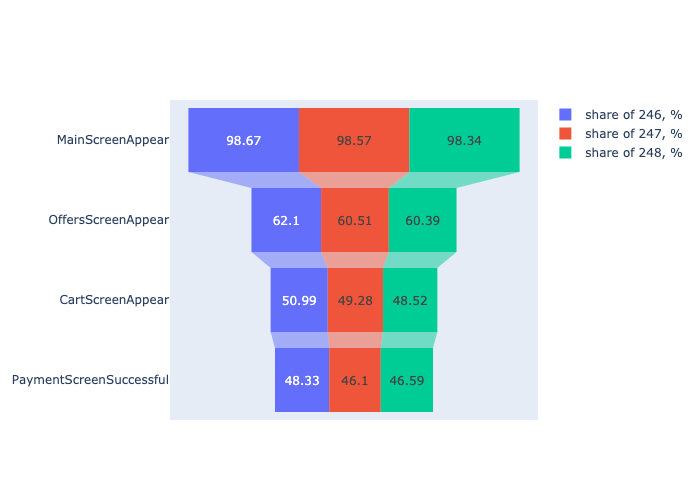

In [34]:
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'share of 246, %',
    y = summary.index,
    x = summary['share of 246, %'],
    ))

fig.add_trace(go.Funnel(
    name = 'share of 247, %',
    y = summary.index,
    x = summary['share of 247, %'],
    ))

fig.add_trace(go.Funnel(
    name = 'share of 248, %',
    y = summary.index,
    x = summary['share of 248, %'],
    ))


fig.show("png")

Видно, что разницы между группами практически нет.

Выберем самое популярное событие. Посчитем число пользователей, совершивших это событие в каждой из контрольных групп. Посчитем долю пользователей, совершивших это событие.

In [35]:
summary['246+247'] = summary['246'] + summary['247']
summary

exp_id,246,247,248,"share of 246, %","share of 247, %","share of 248, %",246+247
event_name,,,,,,,
MainScreenAppear,2450,2476,2493,98.67,98.57,98.34,4926
OffersScreenAppear,1542,1520,1531,62.10,60.51,60.39,3062
CartScreenAppear,1266,1238,1230,50.99,49.28,48.52,2504
PaymentScreenSuccessful,1200,1158,1181,48.33,46.10,46.59,2358


Как было ранее показано, самое популярное событие - показ главного экрана (MainScreenAppear)

Проверим, будет ли отличие между группами статистически достоверным.

Воспользуемся Z-критерием для проверки каждой из групп - 246 и 247. 

Гипотезы:
- H0 - между долями НЕТ стат значимых различий
- H1 - между долями ЕСТЬ стат значимых различий
- Примем для себя уровень значимости alpha = .05

In [36]:
def z_test(exp1, exp2, event, alpha): 
    p1_ev = summary.loc[event, exp1]
    p2_ev = summary.loc[event, exp2] 
    p1_us = nunique_users.loc[exp1, 'uid'] 
    p2_us = nunique_users.loc[exp2, 'uid'] 
    p1 = p1_ev / p1_us 
    p2 = p2_ev / p2_us 
    difference = p1 - p2
    p_combined = (p1_ev + p2_ev) / (p1_us + p2_us) 
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1 / p1_us + 1 / p2_us))
    distr = stats.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('Проверка для события {}:'.format(event))
    print('p-значение: {p_value:.5f}'.format(p_value=p_value))
    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу")
    else:
        print("Не получилось отвергнуть нулевую гипотезу")

In [37]:
for event in summary.index:
    z_test('246', '247', event, 0.05)
    print()

Проверка для события MainScreenAppear:
p-значение: 0.75267
Не получилось отвергнуть нулевую гипотезу

Проверка для события OffersScreenAppear:
p-значение: 0.24786
Не получилось отвергнуть нулевую гипотезу

Проверка для события CartScreenAppear:
p-значение: 0.22868
Не получилось отвергнуть нулевую гипотезу

Проверка для события PaymentScreenSuccessful:
p-значение: 0.11447
Не получилось отвергнуть нулевую гипотезу



Сравним результаты между группой 246 и 248:

In [38]:
for event in summary.index:
    z_test('246', '248', event, 0.05)
    print()

Проверка для события MainScreenAppear:
p-значение: 0.33871
Не получилось отвергнуть нулевую гипотезу

Проверка для события OffersScreenAppear:
p-значение: 0.21442
Не получилось отвергнуть нулевую гипотезу

Проверка для события CartScreenAppear:
p-значение: 0.08067
Не получилось отвергнуть нулевую гипотезу

Проверка для события PaymentScreenSuccessful:
p-значение: 0.21693
Не получилось отвергнуть нулевую гипотезу



Сравним результаты между группой 247 и 248:

In [39]:
for event in summary.index:
    z_test('247', '248', event, 0.05)
    print()

Проверка для события MainScreenAppear:
p-значение: 0.51950
Не получилось отвергнуть нулевую гипотезу

Проверка для события OffersScreenAppear:
p-значение: 0.93338
Не получилось отвергнуть нулевую гипотезу

Проверка для события CartScreenAppear:
p-значение: 0.58783
Не получилось отвергнуть нулевую гипотезу

Проверка для события PaymentScreenSuccessful:
p-значение: 0.72757
Не получилось отвергнуть нулевую гипотезу



Сравним результаты между объединенной группой 246+247 и 248:

In [40]:
for event in summary.index:
    z_test('246+247', '247', event, 0.05)
    print()

Проверка для события MainScreenAppear:
p-значение: 0.85706
Не получилось отвергнуть нулевую гипотезу

Проверка для события OffersScreenAppear:
p-значение: 0.50685
Не получилось отвергнуть нулевую гипотезу

Проверка для события CartScreenAppear:
p-значение: 0.48874
Не получилось отвергнуть нулевую гипотезу

Проверка для события PaymentScreenSuccessful:
p-значение: 0.36378
Не получилось отвергнуть нулевую гипотезу



Основной вывод по всем группам - нельзя утверждать что существует различия между группами. Но можно сказать, что разбиение на группы работает корректно.

В качестве уровеня значимости было приянто значение в 5%. Провели 4 А/А теста, и 12 А/В тестов.

## Вывод:
Провели исследование результатов A/A/B-эксперимента по изменению шрифта во всём приложении. Пользователи были разбиты на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. 
1. Загрузили и подготовили данные: исправили типы данных, избавились от дубликатов. После обработки данных потеряли около 1% событий.
2. Отбросили события до 2019-08-01, т.к. до 2019-08-01 данные не полные. Отбросили событие Tutorial, как не имеющее отношение к поведению пользователей и эксперименту.  
3. Изучили воронку событий и посторили график. От первого события(главный экран) до последнего (успешная оплата) доходит 47.7% пользователей. Больше всего пользователей теряется на шаге перехода с главного экрана (MainScreenAppear) к ассортименту (OffersScreenAppear) - 38.1%
4. Изучили непосредственно результаты A/A/B-эксперимента. Воспользовались Z-критерием для проверки гипотез. Исследования показало, что статичстически значемые изменения в поведении пользователей отсутствуют, т.е. замена шрифтов никак не повлияла на пользователей ни в худшую, ни в лучшую сторону.